# Visualizing Iowan's consumption of liquor from 2014-2017 and around the 2016 Presendential Election

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pyproj
import rasterio
import rasterstats
import matplotlib.patches as mpatches
import matplotlib.colors
import datetime

In [4]:
iowa=geopandas.read_file("IA_counties/IA_counties.shp") #read in Iowa shape file
iowa.NAME10=iowa.NAME10.str.lower() #lowercase all county names to make merging easier with the liquor dataset
pd.set_option('display.max_columns', None) #did this to see all columns in iowa.head()

In [5]:
iowa.columns

Index(['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R', 'PRES12OTH', 'TOTVOT16', 'PRES16D', 'PRES16R', 'PRES16OTH',
       'CD', 'geometry'],
      dtype='object')

In [6]:
iowa['majD']=iowa.PRES16D>iowa.PRES16R #create boolean for MAJORITY DEMOCRATS (majD) for 2016
colors={True:'blue',False:'red'} #create color dict that will be used later for this column

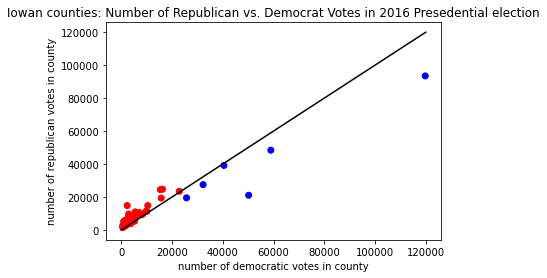

In [7]:
plt.scatter(x=iowa.PRES16D,y=iowa.PRES16R,c=iowa['majD'].map(colors));
plt.xlabel('number of democratic votes in county');
plt.ylabel('number of republican votes in county');
plt.title('Iowan counties: Number of Republican vs. Democrat Votes in 2016 Presedential election')
plt.plot([0,120000],[0,120000],color='black');


# The above chart is very important for a few reasons:
1. We see that larger populations tend to have a democratic majority
2. This will be an issue when looking at liquor sales because larger populations will almost certainly have higher liquor consumption because there are more people.
3. The way forward: try and do per capita consumption. If we don't democratic majority counties will look like they drink **A LOT**

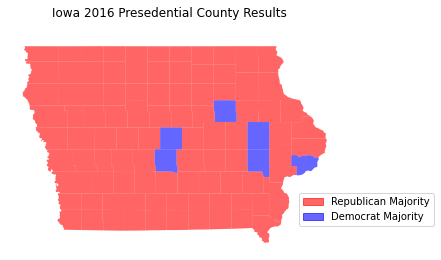

In [9]:
#just creating a map for republican vs. democratic majority counties. I verified it. It is correct
iowa.plot(color=iowa['majD'].map(colors),alpha=.6);
plt.suptitle('Iowa 2016 Presedential County Results');
dem=mpatches.Patch(color='blue', alpha=.6 ,label='Democrat Majority');
rep=mpatches.Patch(color='red', alpha=.6 ,label='Republican Majority');
plt.legend(handles=[rep,dem], loc='lower right',bbox_to_anchor=(1.29,.1));
plt.axis('off');
#next try to do it gradient w/ color scale 

In [10]:
iowa['percR']=(iowa.PRES16R/iowa.TOTVOT16)*100 #create column for percent of votes to Republicans
iowa['percD']=(iowa.PRES16D/iowa.TOTVOT16)*100 #create column for percent of votes to Democrats

# Consumption of liquor over time for Iowan counties based on party majority

In [11]:
iowa=iowa.drop(columns=['STATEFP10', 'COUNTYFP10', 'GEOID10','NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10','HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R','NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'PRES12OTH'])

In [13]:
#pop. of all democratic counties and republican counties, respectively 
x=iowa.loc[iowa.majD==True][['TOTPOP']]
x=sum(x.TOTPOP) #population of all democratic majority counties
y=iowa.loc[iowa.majD==False][['TOTPOP']]
y=sum(y.TOTPOP) #popoulation of all republican majority counties
z=round((x/(x+y))*100,2)
print('{}% is the percent of the population in Iowa that lives in the 6 Democratic majority counties in 2016'.format(z))

38.03% is the percent of the population in Iowa that lives in the 6 Democratic majority counties in 2016


In [39]:
monsale=pd.read_csv("monthly_county_sales.csv") #read in cleaned monthly liquor sale data

In [15]:
imsale=pd.merge(monsale,iowa,left_on='County',right_on='NAME10',indicator=True) #merge shape file and liqour sale data

In [16]:
repc=imsale.loc[imsale.majD==False] #create object for Republican majority counties 
demc=imsale.loc[imsale.majD==True] #create object for Democratic majority counties 

In [17]:
rep=repc.groupby(by='Date').sum('Sales (Dollars)') #monthly total sales of liquor for Republican majority counties
dem=demc.groupby(by='Date').sum('Sales (Dollars)') #monthly total sales of liquor for Democratic majority counties 

In [18]:
rep['Per_cap_liq_cons']=rep['Sales (Dollars)']/y #per capita consumption by month for Republican (Rep) counties ($/person every month)
dem['Per_cap_liq_cons']=rep['Sales (Dollars)']/x #per capita consumption by month for Democratic (Dem) counties ($/person every month)

In [21]:
rep['Per_cap_liq_cons'].mean() #average number of dollars per person spent each month on liqour in Rep counties

5.1667262114501975

In [23]:
dem['Per_cap_liq_cons'].mean() #average number of dollars per person spent each month on liquor in Dem counties
#Dem counties have significantly higher consumption per person. College towns???

8.418314257840748

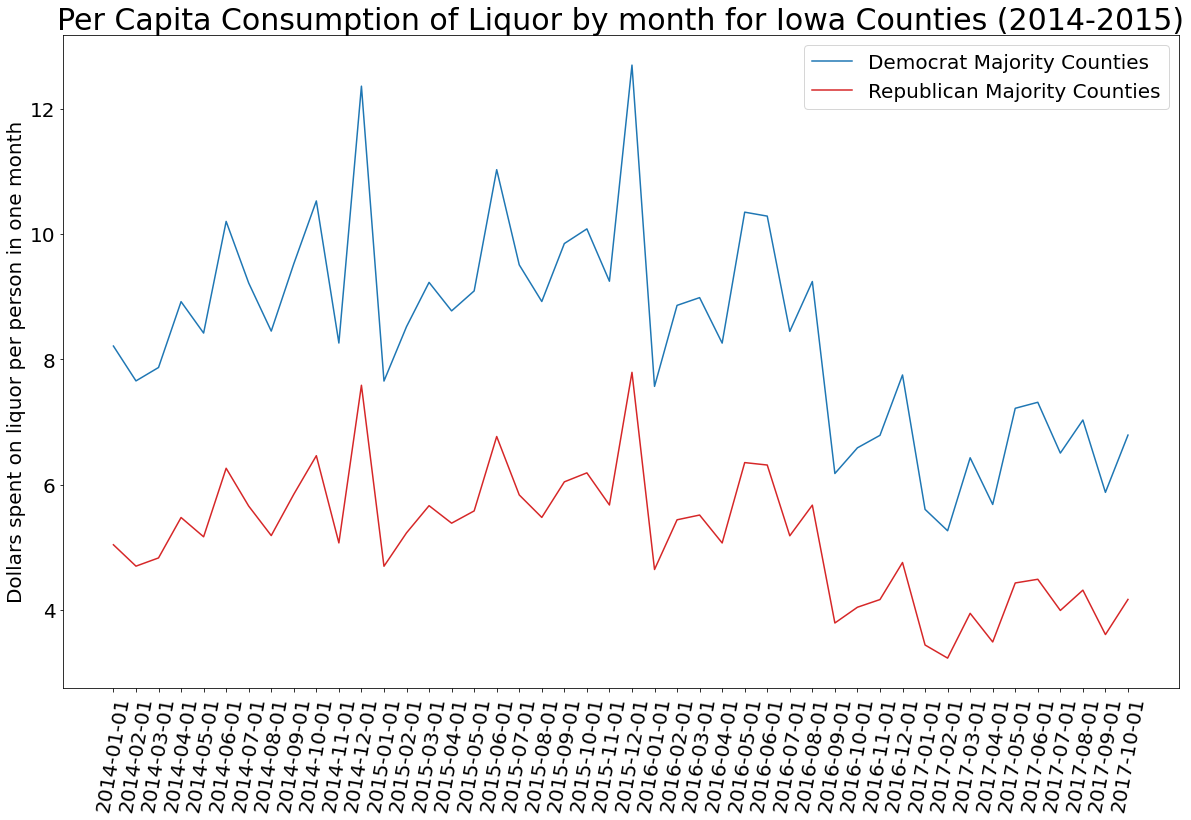

In [24]:
plt.figure(figsize=(20,12))
plt.plot(dem['Per_cap_liq_cons'], color='tab:blue',label='Democrat Majority Counties');
plt.plot(rep['Per_cap_liq_cons'],color='tab:red',label='Republican Majority Counties');
plt.legend(loc='upper right',bbox_to_anchor=(1,1),fontsize=20);
plt.title('Per Capita Consumption of Liquor by month for Iowa Counties (2014-2015)',fontsize=30);
plt.xticks(rotation=80,fontsize=20)
plt.ylabel('Dollars spent on liquor per person in one month',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Liqour Consumption around 2016 election 

In [58]:
dsale=pd.read_csv("daily_county_sales.csv") #read in daily sales of liquor 

In [59]:
dsale.Date=pd.to_datetime(dsale.Date)
dsale['dofweek']=dsale.Date.dt.day_name()

In [60]:
idsale=pd.merge(dsale,iowa,left_on='County',right_on='NAME10',indicator=True) #merge liquor sales with iowa county info

In [61]:
repc=idsale.loc[idsale.majD==False] #subset Rep counties
demc=idsale.loc[idsale.majD==True] #subset Dem counties 

In [62]:
rep=repc.groupby(by='Date').sum('Sales (Dollars)')
dem=demc.groupby(by='Date').sum('Sales (Dollars)')

In [63]:
rep['Per_cap_liq_cons']=rep['Sales (Dollars)']/y
dem['Per_cap_liq_cons']=rep['Sales (Dollars)']/x

In [64]:
rep=rep.reset_index() #had to reset index to have Date column to mess with
dem=dem.reset_index()

In [65]:
#converting Date columns to datetime to extract the days of the week 
dem['Date']=pd.to_datetime(dem.Date)
dem['dofweek']=dem['Date'].dt.day_name()

rep['Date']=pd.to_datetime(rep.Date)
rep['dofweek']=rep['Date'].dt.day_name()

In [66]:
#select dates around the 2016 election
elecrep=rep.loc[(rep.Date>='2016-10-15') & (rep.Date<='2016-11-15')] 
elecdem=dem.loc[(dem.Date>='2016-10-15') & (dem.Date<='2016-11-15')]

In [67]:
elecdem=elecdem.set_index('Date') #had to set the Date column back to make creating a graph easier
elecrep=elecrep.set_index('Date')

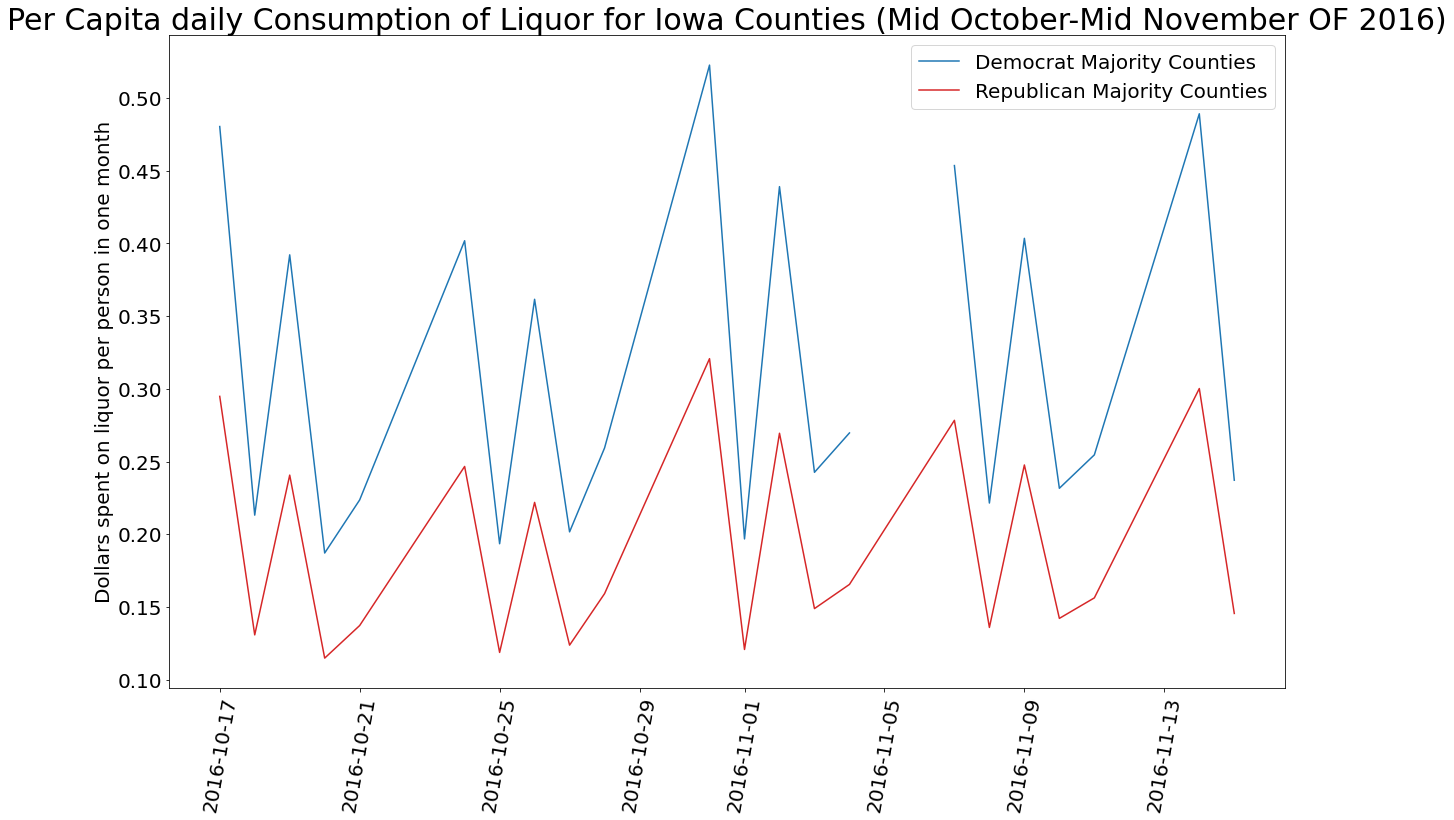

In [68]:
plt.figure(figsize=(20,12))
plt.plot(elecdem['Per_cap_liq_cons'],  color='tab:blue',label='Democrat Majority Counties');
plt.plot(elecrep['Per_cap_liq_cons'],color='tab:red',label='Republican Majority Counties');
plt.legend(loc='upper right',bbox_to_anchor=(1,1),fontsize=20);
plt.title('Per Capita daily Consumption of Liquor for Iowa Counties (Mid October-Mid November OF 2016)',fontsize=30);
plt.xticks(rotation=80,fontsize=20)
plt.ylabel('Dollars spent on liquor per person in one month',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# A lot of weekends missing from data

In [71]:
#missing all of Sunday and Saturday has only 1 observation
elecdem.dofweek.value_counts()

Monday       5
Tuesday      5
Friday       4
Thursday     4
Wednesday    4
Saturday     1
Name: dofweek, dtype: int64

In [72]:
#missing both Sunday and Saturday
elecrep.dofweek.value_counts()

Monday       5
Tuesday      5
Friday       4
Thursday     4
Wednesday    4
Name: dofweek, dtype: int64